In [99]:
# Run opencritic_api__games.ipynb first.
import pandas as pd
import json
import ast
import numpy as np
import math
import missingno as msno

In [100]:
raw_reviews_df = pd.read_csv('/Users/connor.stevens/Library/Mobile Documents/com~apple~CloudDocs/Masters Thesis Spring 2023/data/final_df (1).csv')
raw_reviews_df.head()

,Unnamed: 0,igdb_name,opencritic_name,opencritic_id,igdb_id,dist,first_release_date,involved_companies,game_modes,genres,...,topCriticScore,tier,percentile,num_platforms,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,tenthReviewDate,criticalReviewDate
0,0,The Last Guardian,The Last Guardian,1524,117,0.0,1480982400,"[{'id': 36389, 'company': {'id': 44, 'name': '...","[{'id': 1, 'name': 'Single player'}]","[{'id': 8, 'name': 'Platform'}, {'id': 9, 'nam...",...,80.528736,Strong,83.0,NaN,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,2016-12-05T05:00:00.000Z,2016-12-05T05:00:00.000Z
1,1,Final Fantasy XV,Final Fantasy XV,1512,359,0.0,1480377600,"[{'id': 53470, 'company': {'id': 2670, 'name':...","[{'id': 1, 'name': 'Single player'}, {'id': 3,...","[{'id': 12, 'name': 'Role-playing (RPG)'}, {'i...",...,80.736842,Strong,83.0,NaN,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,2016-11-28T05:00:00.000Z,2016-11-28T05:00:00.000Z
2,2,Prison Architect,Prison Architect,1942,1338,0.0,1444089600,"[{'id': 201720, 'company': {'id': 1224, 'name'...","[{'id': 1, 'name': 'Single player'}, {'id': 2,...","[{'id': 13, 'name': 'Simulator'}, {'id': 15, '...",...,79.893617,Strong,76.0,NaN,NaN,2015-10-06T00:00:00.000Z,2015-10-05T04:00:00.000Z,2018-10-29T04:00:00.000Z,2015-10-07T04:00:00.000Z,2015-10-19T04:00:00.000Z
3,3,Mirror's Edge Catalyst,Mirror's Edge Catalyst,1549,2112,0.0,1465257600,"[{'id': 7372, 'company': {'id': 1, 'name': 'El...","[{'id': 1, 'name': 'Single player'}, {'id': 2,...","[{'id': 4, 'name': 'Fighting'}, {'id': 31, 'na...",...,70.168831,Fair,44.0,NaN,2016-06-06T16:03:00.000Z,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z,2016-06-06T04:00:00.000Z,2016-06-06T04:00:00.000Z
4,4,Star Wars Battlefront,Star Wars Battlefront,1511,2113,0.0,1447718400,"[{'id': 56415, 'company': {'id': 1, 'name': 'E...","[{'id': 1, 'name': 'Single player'}, {'id': 2,...","[{'id': 5, 'name': 'Shooter'}]",...,71.183908,Fair,48.0,NaN,2015-11-17T05:05:00.000Z,2015-11-17T00:00:00.000Z,2015-11-08T05:00:00.000Z,2017-02-13T05:00:00.000Z,2015-11-16T05:00:00.000Z,2015-11-17T05:00:00.000Z


<Axes: >

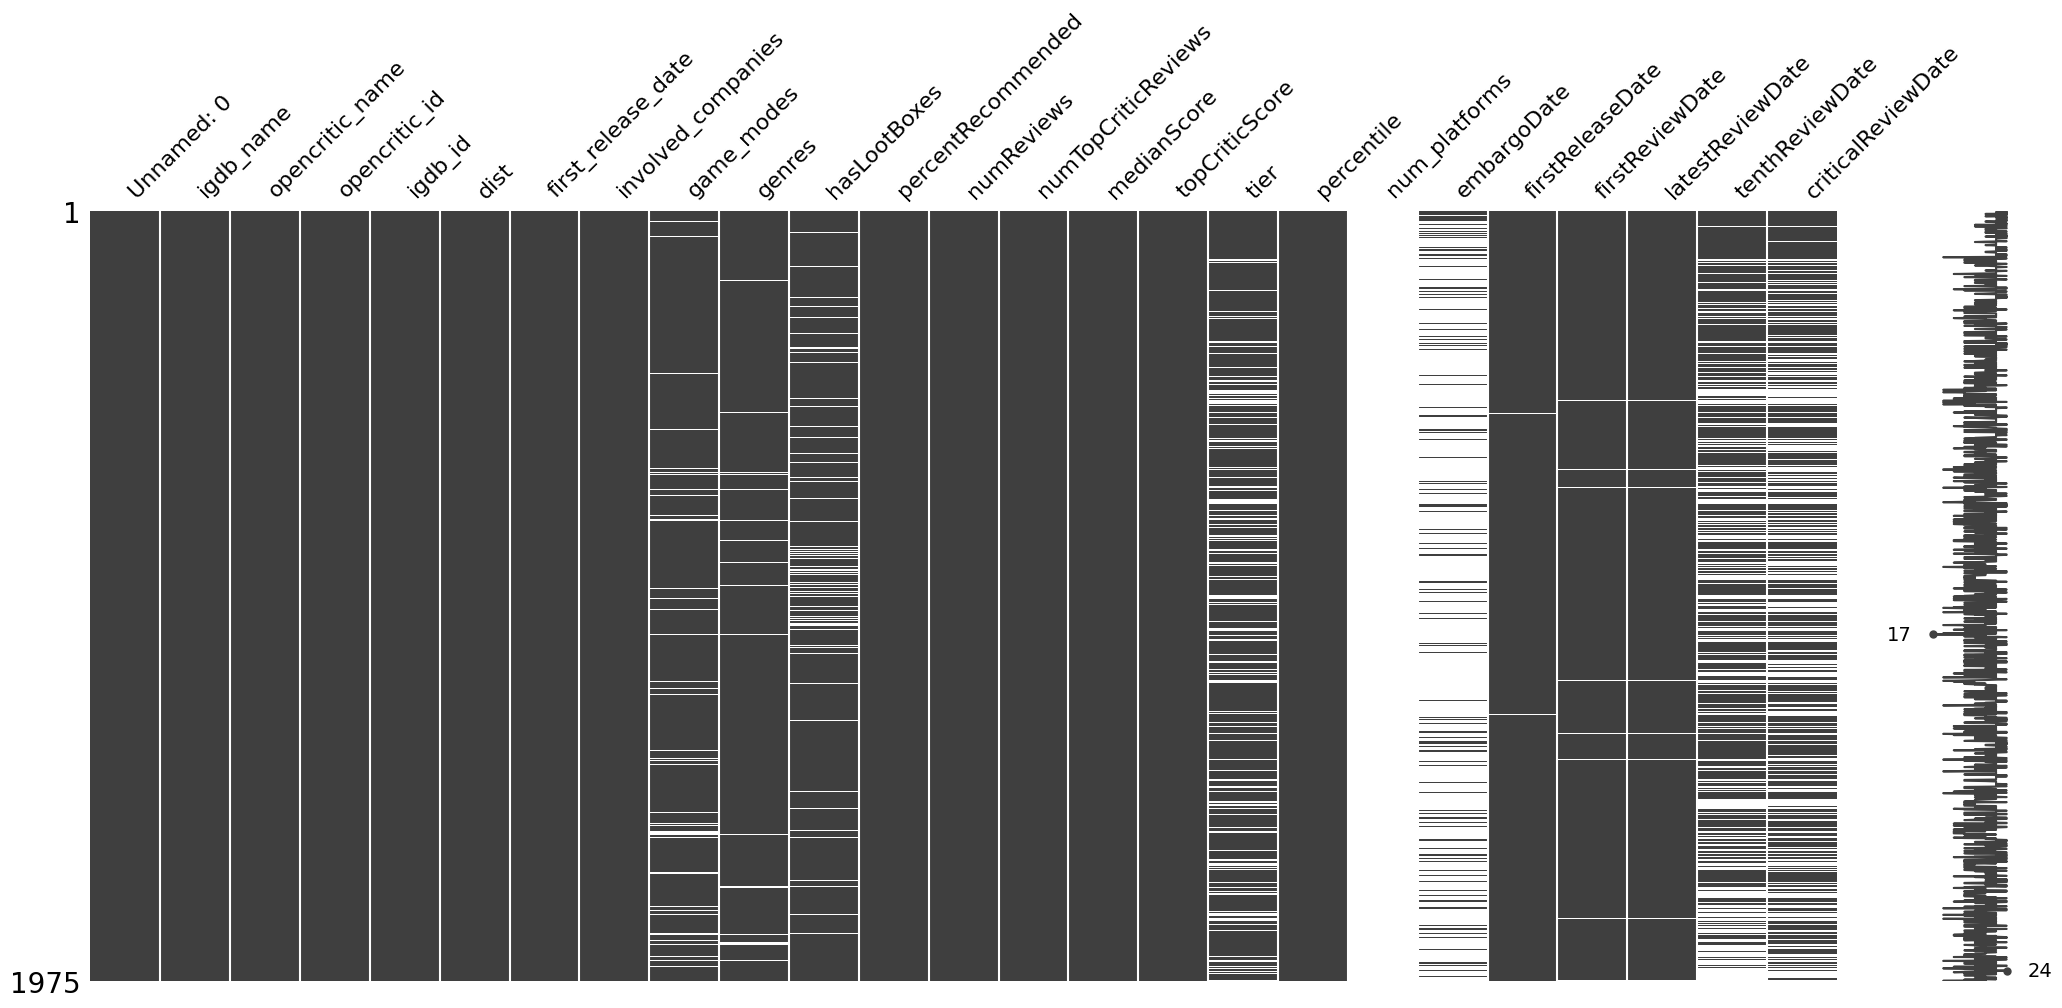

In [101]:
# Check how much missing data is present in the reviews dataset.
%matplotlib inline

msno.matrix(raw_reviews_df)

Thanks to the data obtained from IGDB, involved_companies, game_modes and genres are not needed and can be dropped. Of the OpenCritic-specific data; tier, num_platforms, embargoDate, tenthReviewDate and criticalReviewDate have too many missing values to include. hasLootBoxes, firstReleaseDate, firstReviewDate and latestReviewDate have some missing values but will be included with missing values handled later.

In [102]:
# Drop columns.
columns_to_drop = ['involved_companies', 'game_modes', 'genres', 'tier', 'num_platforms', 'embargoDate', 'tenthReviewDate', 'criticalReviewDate']
raw_reviews_df = raw_reviews_df.drop(columns_to_drop, axis=1)
raw_reviews_df.head()

,Unnamed: 0,igdb_name,opencritic_name,opencritic_id,igdb_id,dist,first_release_date,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,firstReleaseDate,firstReviewDate,latestReviewDate
0,0,The Last Guardian,The Last Guardian,1524,117,0.0,1480982400,False,70.491803,128.0,96.0,85.0,80.528736,83.0,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z
1,1,Final Fantasy XV,Final Fantasy XV,1512,359,0.0,1480377600,False,74.305556,148.0,95.0,85.0,80.736842,83.0,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z
2,2,Prison Architect,Prison Architect,1942,1338,0.0,1444089600,False,81.355932,61.0,47.0,80.0,79.893617,76.0,2015-10-06T00:00:00.000Z,2015-10-05T04:00:00.000Z,2018-10-29T04:00:00.000Z
3,3,Mirror's Edge Catalyst,Mirror's Edge Catalyst,1549,2112,0.0,1465257600,False,29.166667,103.0,77.0,70.0,70.168831,44.0,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z
4,4,Star Wars Battlefront,Star Wars Battlefront,1511,2113,0.0,1447718400,False,33.009709,111.0,99.0,70.0,71.183908,48.0,2015-11-17T00:00:00.000Z,2015-11-08T05:00:00.000Z,2017-02-13T05:00:00.000Z


In [103]:
raw_reviews_df[raw_reviews_df['dist'] == 0]

,Unnamed: 0,igdb_name,opencritic_name,opencritic_id,igdb_id,dist,first_release_date,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,firstReleaseDate,firstReviewDate,latestReviewDate
0,0,The Last Guardian,The Last Guardian,1524,117,0.0,1480982400,False,70.491803,128.0,96.0,85.0,80.528736,83.0,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z
1,1,Final Fantasy XV,Final Fantasy XV,1512,359,0.0,1480377600,False,74.305556,148.0,95.0,85.0,80.736842,83.0,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z
2,2,Prison Architect,Prison Architect,1942,1338,0.0,1444089600,False,81.355932,61.0,47.0,80.0,79.893617,76.0,2015-10-06T00:00:00.000Z,2015-10-05T04:00:00.000Z,2018-10-29T04:00:00.000Z
3,3,Mirror's Edge Catalyst,Mirror's Edge Catalyst,1549,2112,0.0,1465257600,False,29.166667,103.0,77.0,70.0,70.168831,44.0,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z
4,4,Star Wars Battlefront,Star Wars Battlefront,1511,2113,0.0,1447718400,False,33.009709,111.0,99.0,70.0,71.183908,48.0,2015-11-17T00:00:00.000Z,2015-11-08T05:00:00.000Z,2017-02-13T05:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,1938,Age of Wonders 4,Age of Wonders 4,14350,232571,0.0,1682985600,False,95.833333,27.0,23.0,83.0,82.222222,89.0,2023-05-02T00:00:00.000Z,2023-04-27T00:00:00.000Z,2023-05-15T00:00:00.000Z
1945,1945,WBSC eBaseball: Power Pros,WBSC eBaseball: Power Pros,14279,236674,0.0,1675814400,False,-1.000000,4.0,3.0,-1.0,80.000000,83.0,2023-02-08T00:00:00.000Z,2023-02-09T00:00:00.000Z,2023-03-29T00:00:00.000Z
1946,1946,Paranormasight: The Seven Mysteries of Honjo,PARANORMASIGHT: The Seven Mysteries of Honjo,14408,236694,0.0,1678233600,False,86.111111,38.0,22.0,88.0,81.421053,86.0,2023-03-08T00:00:00.000Z,2023-03-08T00:00:00.000Z,2023-05-11T00:00:00.000Z
1953,1953,AFL 23,AFL 23,14912,240298,0.0,1683158400,False,-1.000000,3.0,3.0,-1.0,63.333333,23.0,2023-05-03T00:00:00.000Z,2023-05-10T00:00:00.000Z,2023-05-15T00:00:00.000Z


In [104]:
# Import igdb_games_cleaned.csv

igdb_games = pd.read_csv('igdb_games_cleaned.csv')
igdb_games.head()

,Unnamed: 0,id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,pub1_stock_id,pub2_stock_id
0,0,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,0
1,1,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,0
2,3,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,0,0,1,0
3,5,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,0,0,13634,0
4,6,2933,1548374400,Kingdom Hearts III,kingdom-hearts-iii,False,True,False,26,0,26,0


In [105]:
# Rename id to igdb_id for joining with raw_reviews_df.
igdb_games = igdb_games.rename(columns={"id": "igdb_id"})
igdb_games.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,pub1_stock_id,pub2_stock_id
0,0,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,0
1,1,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,0
2,3,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,0,0,1,0
3,5,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,0,0,13634,0
4,6,2933,1548374400,Kingdom Hearts III,kingdom-hearts-iii,False,True,False,26,0,26,0


Now that the reviews and games both have an igdb_id and a unix time release date, the two can be joined.

In [106]:
# Join the reviews to the games dataset.
games_reviews_df = pd.merge(igdb_games, raw_reviews_df, how='left', on=['igdb_id', 'first_release_date'])
games_reviews_df.head()

,Unnamed: 0_x,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,...,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,firstReleaseDate,firstReviewDate,latestReviewDate
0,0,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,...,False,70.491803,128.0,96.0,85.0,80.528736,83.0,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z
1,1,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,...,False,74.305556,148.0,95.0,85.0,80.736842,83.0,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z
2,3,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,0,0,...,False,29.166667,103.0,77.0,70.0,70.168831,44.0,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z
3,5,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,0,0,...,False,93.103448,31.0,28.0,88.0,85.464286,95.0,2016-03-29T00:00:00.000Z,2016-03-28T04:00:00.000Z,2016-06-15T04:00:00.000Z
4,6,2933,1548374400,Kingdom Hearts III,kingdom-hearts-iii,False,True,False,26,0,...,False,84.137931,148.0,105.0,85.0,84.202020,93.0,2019-01-29T00:00:00.000Z,2019-01-24T05:00:00.000Z,2022-04-01T00:00:00.000Z


In [107]:
games_reviews_df.columns

Index(['Unnamed: 0_x', 'igdb_id', 'first_release_date', 'name', 'slug',
       'mature', 'single_player', 'multiplayer', 'dev1_stock_id',
       'dev2_stock_id', 'pub1_stock_id', 'pub2_stock_id', 'Unnamed: 0_y',
       'igdb_name', 'opencritic_name', 'opencritic_id', 'dist', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'firstReleaseDate',
       'firstReviewDate', 'latestReviewDate'],
      dtype='object')

In [108]:
# Drop unused columns.
games_reviews_df = games_reviews_df.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
games_reviews_df.columns

Index(['igdb_id', 'first_release_date', 'name', 'slug', 'mature',
       'single_player', 'multiplayer', 'dev1_stock_id', 'dev2_stock_id',
       'pub1_stock_id', 'pub2_stock_id', 'igdb_name', 'opencritic_name',
       'opencritic_id', 'dist', 'hasLootBoxes', 'percentRecommended',
       'numReviews', 'numTopCriticReviews', 'medianScore', 'topCriticScore',
       'percentile', 'firstReleaseDate', 'firstReviewDate',
       'latestReviewDate'],
      dtype='object')

In [110]:

long_company_ids = pd.melt(games_reviews_df, id_vars='igdb_id', value_vars=['dev1_stock_id', 'dev2_stock_id', 'pub1_stock_id', 'pub2_stock_id'])
long_company_ids = long_company_ids.rename(columns={"value": "igdb_company_ids"})
print(long_company_ids['variable'].value_counts())
long_company_ids.head()

variable
dev1_stock_id    982
dev2_stock_id    982
pub1_stock_id    982
pub2_stock_id    982
Name: count, dtype: int64


,igdb_id,variable,igdb_company_ids
0,117,dev1_stock_id,0
1,359,dev1_stock_id,26
2,2112,dev1_stock_id,0
3,2212,dev1_stock_id,0
4,2933,dev1_stock_id,26


In [111]:
test = pd.merge(games_reviews_df, long_company_ids, how='left', on='igdb_id')
test.head()

,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,pub1_stock_id,...,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_ids
0,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,128.0,96.0,85.0,80.528736,83.0,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,dev1_stock_id,0
1,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,128.0,96.0,85.0,80.528736,83.0,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,dev2_stock_id,0
2,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,128.0,96.0,85.0,80.528736,83.0,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100
3,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,128.0,96.0,85.0,80.528736,83.0,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub2_stock_id,0
4,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,...,148.0,95.0,85.0,80.736842,83.0,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,dev1_stock_id,26
